# File Processing 
----

#### Data cleaning and formatting is done to create Pandas dataframes to be used for mapping and visualization of the data.  The primary data set comes from an api generated by CBS Sports News and hosted by Amazon Web Services.  The data set is a listing of College/University Sports Events that are scheduled to be streamed by video or audio.  The ask by CBS Sports News is to take the API that is generated weekly and create a visualization of the scheduled events to be broadcast to help anticipate staffing needs on a daily basis.  For CBS Sports News, a heat map/and or graphic visualization of the games to be broadcast by specific pub points will be used to deliver this information.   Further analysis of the events data, will be done using information gathered from a listing of Universities and Colleges to get location data to create maps and visualizations of the events held at specific locations.




In [8]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json as js
from scipy.stats import linregress

# Import API key - usng CBS keys - not used yet
#from api_keys import sport_key
from config import gkey
from config import scorecard_key

# Incorporated citipy to determine city based on latitude and longitude
#from citipy import citipy

# Input test file (JSON).
input_data_file01="Resources/Events.json"
input_data_file02="Resources/MERGED2018_19_PP.csv"
output_data_file = "eventsMaster.csv"


# Steps for analyzing / cleaning data

Step1 - Capture data from the CBS Sports News API, filter, clean and assemble a dataframe that has school location data and pub points data 
----

Need: 
'count'  - gives the number of events in the list
nested in 'count'
'events' - nested
 by 'contenttype'
     'eventstate' 'scheduled'
     'eventstatus' 'live'
     'eventtype' 'game'
     'is_passthrough' 'False'
     'prismid': '27a62c10-4a15-42ae-a81b-9b31c346ffb9',  [unique id]
     'schedule': {'endtimestamp': 1618181100,
                          'starttimebuffer': 0,
                          'starttimestamp': 1618163100},
     'school': 'nwst',
     'school_name': 'Northwestern State University',
     'sport': 'm-basebl',
     'sport_name': 'Baseball',



In [9]:
#Step 1
with open(input_data_file01) as f:
  data = js.load(f)
#gives a dictionary
#data.values()


In [10]:
import pprint
#pp = pprint.PrettyPrinter(depth=4)
#pp.pprint(data)


In [11]:
#another way to print
#pp.pprint(f'Dictionary comprehension: {data}')

In [12]:
data.keys()

dict_keys(['events', 'count'])

In [13]:
#Step 1
#checking to remove passthroughs
newDict={}
print(data['count'])
newCount=0
#filter out the passthrough records
Counts=data['count']
#first look for passthrough = True
for index in range(1,Counts):
    if data['events'][index]['is_passthrough']==False:
        newDict=data
        newCount= newCount+1
    
#print(newDict)    
print(f'filtered data counts {newCount}')

706
filtered data counts 558


In [14]:
#Step 1
#create the master filtered data frame
ID=[]
Type=[]
Scheduled=[]
Status=[]
CType=[]
Pass=[]
Start=[]
End=[]
Event_Title=[]
School_Name=[]
School_Code=[]
Game=[]
PubPoint=[]


for index in range(1,newCount):
    try:
        ID.append(newDict['events'][index]['prismid'])
        Scheduled.append(newDict['events'][index]['eventstate'])
        Pass.append(newDict['events'][index]['is_passthrough'])
        Start.append(newDict['events'][index]['starttime'])
        End.append(newDict['events'][index]['endtime'])
        Event_Title.append(newDict['events'][index]['eventtitle'])
        School_Name.append(newDict['events'][index]['school_name'])
        School_Code.append(newDict['events'][index]['school'])
        Game.append(newDict['events'][index]['sport_name'])
        
    except ValueError:
        continue
    except KeyError:
        print(index)
        continue
             
        
  
    
event_df=pd.DataFrame(ID)
event_df['Scheduled']=Scheduled
event_df['PassThru']=Pass
event_df['Start Time']=Start
event_df['End Time']=End
event_df['Event']=Event_Title
event_df['School Name']=School_Name
event_df['School Code']=School_Code
event_df['Sport']=Game
event_df.rename(columns={0:'ID'},inplace=True)
event_df.set_index('ID',inplace=True)



In [15]:
event_df.head()

,Scheduled,PassThru,Start Time,End Time,Event,School Name,School Code,Sport
ID,,,,,,,,
80454be6-1828-499d-b398-6c3b38f30a28,scheduled,False,1618008600,1618020000,SB: Middle Tennessee vs Marshall,Conference USA,c-usa,Softball
f9547332-f5d5-49e0-bc8f-63ec97466837,scheduled,False,1618073400,1618084800,vs. Ashland,Davenport University,dave,Baseball
cc6a38ff-0b50-4d79-b47f-320b77188954,scheduled,False,1618076700,1618110000,UWG Baseball vs. Union,University of West Georgia,wega,Baseball
bc057b3e-4358-4089-aea2-05ac0004396c,scheduled,False,1617822000,1617840000,Bethany at W&J,Presidents Athletic Conference,pac,Softball
1281a5f2-414e-4349-ab70-63900958ec47,scheduled,False,1618008600,1618020000,BSB AUDIO: Charlotte at FIU,Conference USA,c-usa,Baseball


In [16]:
event_df.columns

Index(['Scheduled', 'PassThru', 'Start Time', 'End Time', 'Event',
       'School Name', 'School Code', 'Sport'],
      dtype='object')

In [17]:
#Step 1
#get the pass through record values for each prismid
with open(input_data_file01) as f:
  filter_set = js.load(f)
#gives a dictionary
filter_set.values()

prismid=[]
Pass=[]
contenttype=[]
pubPoint=[]
#filter out the passthrough records
Counters=filter_set['count']

pr_count=0
content_count=0
pass_count=0
pub_count=0
#first look for passthrough = True
for index in range(1,Counts):
   try:     
    
    if filter_set['events'][index]['is_passthrough']==True:
        Pass.append(filter_set['events'][index]['is_passthrough'])
        prismid.append(filter_set['events'][index]['prismid'])
        contenttype.append(filter_set['events'][index]['contenttype'])
        pubPoint.append(filter_set['events'][index]['ingest']['primary']['pub_point'])
   except KeyError:
        continue

count_pid=len(prismid)
print(count_pid)        
#count_contenttype=len(contenttype)  
#count_pass=len(Pass)
#print(count_pass)
#print(f'pass_throughs are :{Pass}')  
count_pubs=len(pubPoint)
print(count_pubs)
#print(f'pubs are: {pubPoint}')
  
#print(f'prismids to exclude are :{prismid}')

147
0


In [18]:
#Step 1
#create the pub poing list to merge back to the master filtered data frame
counter=0
xcount=0
prID=[]
PP=[]
# the pub points
for index in range(1,newCount):
    if newDict['events'][index]['prismid'] in prismid:
        xcount=+1
    elif newDict['events'][index]['prismid']not in prismid:
        prID.append(newDict['events'][index]['prismid'])
        PP.append(newDict['events'][index]['ingest']['primary']['pub_point'])
        
print(xcount)
print(len(prID))  
print(len(PP))

AddPP_df=pd.DataFrame(prID)
AddPP_df['PubPoint']=PP
AddPP_df.rename(columns={0:'ID'},inplace=True)
AddPP_df.set_index('ID',inplace=True)

1
442
442


In [19]:
print(AddPP_df)

                                                  PubPoint
ID                                                        
80454be6-1828-499d-b398-6c3b38f30a28         mtsu_softball
f9547332-f5d5-49e0-bc8f-63ec97466837           davenport_1
cc6a38ff-0b50-4d79-b47f-320b77188954    westgeorgia_audio2
bc057b3e-4358-4089-aea2-05ac0004396c            washjeff_1
1281a5f2-414e-4349-ab70-63900958ec47      charlotte_audio2
...                                                    ...
584cb036-66a8-4a6f-b725-067ffe6c09e0  southalabama_3_audio
a65b3462-a775-445e-b7d2-c330c4476fbe          providence_1
d986f7b6-fea3-4a03-ac1e-8dbfaef364af                 ecu_2
c5127d37-1fa6-418a-aefd-1d1c6a61adcd         cumberlands_2
823a3c4b-c307-4cc0-ad0c-985461829089           villanova_1

[442 rows x 1 columns]


In [20]:
#Step 1
#this join gets the 558 with 442 pub points
working_events=event_df.merge(AddPP_df,how='left', left_on='ID',right_on='ID')
#record checks

working_events.count()

Scheduled      557
PassThru       557
Start Time     557
End Time       557
Event          557
School Name    557
School Code    557
Sport          557
PubPoint       442
dtype: int64

In [41]:
working_events.head(25)

,Scheduled,PassThru,Start Time,End Time,Event,School Name,School Code,Sport,PubPoint
ID,,,,,,,,,
80454be6-1828-499d-b398-6c3b38f30a28,scheduled,False,1618008600,1618020000,SB: Middle Tennessee vs Marshall,Conference USA,c-usa,Softball,mtsu_softball
f9547332-f5d5-49e0-bc8f-63ec97466837,scheduled,False,1618073400,1618084800,vs. Ashland,Davenport University,dave,Baseball,davenport_1
cc6a38ff-0b50-4d79-b47f-320b77188954,scheduled,False,1618076700,1618110000,UWG Baseball vs. Union,University of West Georgia,wega,Baseball,westgeorgia_audio2
bc057b3e-4358-4089-aea2-05ac0004396c,scheduled,False,1617822000,1617840000,Bethany at W&J,Presidents Athletic Conference,pac,Softball,washjeff_1
1281a5f2-414e-4349-ab70-63900958ec47,scheduled,False,1618008600,1618020000,BSB AUDIO: Charlotte at FIU,Conference USA,c-usa,Baseball,charlotte_audio2
59005cbd-3119-417e-b95a-d69076c3638c,scheduled,False,1618076700,1618087500,RIT vs Skidmore,Rochester Institute of Technology,rit,Men's Lacrosse,RIT_2
f65881c2-808f-4051-a06a-e1fdbc35cbea,scheduled,False,1618065900,1618092000,DH vs. Delaware Valley University,Fairleigh Dickinson-College at Florham,fduf,Baseball,fdudevils_2
08b942cb-9ba0-4802-907b-09e67f9af910,scheduled,False,1618008000,1618027200,vs. Texas State,Troy University,troy,Baseball,troy_wtbf_1
d80403c7-52ab-4a74-952c-0a8df85ba807,scheduled,False,1618164000,1618174800,WSOC vs. South Dakota State,Western Illinois University,wil,Women's Soccer,wiu_1


In [22]:
#Extract audio files versus video files
#look at the pub point, it looks like the last 6 digits would appear as _audio2 
# need to check if the number changes or if it is always 2

#Create visualizations for audio versus video, 
#and even look at this in relation to the sport/gender

In [65]:
#get rid of NaN
audio_video_df = working_events.applymap(str)
audio_video_df.head(19)

,Scheduled,PassThru,Start Time,End Time,Event,School Name,School Code,Sport,PubPoint
ID,,,,,,,,,
80454be6-1828-499d-b398-6c3b38f30a28,scheduled,False,1618008600,1618020000,SB: Middle Tennessee vs Marshall,Conference USA,c-usa,Softball,mtsu_softball
f9547332-f5d5-49e0-bc8f-63ec97466837,scheduled,False,1618073400,1618084800,vs. Ashland,Davenport University,dave,Baseball,davenport_1
cc6a38ff-0b50-4d79-b47f-320b77188954,scheduled,False,1618076700,1618110000,UWG Baseball vs. Union,University of West Georgia,wega,Baseball,westgeorgia_audio2
bc057b3e-4358-4089-aea2-05ac0004396c,scheduled,False,1617822000,1617840000,Bethany at W&J,Presidents Athletic Conference,pac,Softball,washjeff_1
1281a5f2-414e-4349-ab70-63900958ec47,scheduled,False,1618008600,1618020000,BSB AUDIO: Charlotte at FIU,Conference USA,c-usa,Baseball,charlotte_audio2
59005cbd-3119-417e-b95a-d69076c3638c,scheduled,False,1618076700,1618087500,RIT vs Skidmore,Rochester Institute of Technology,rit,Men's Lacrosse,RIT_2
f65881c2-808f-4051-a06a-e1fdbc35cbea,scheduled,False,1618065900,1618092000,DH vs. Delaware Valley University,Fairleigh Dickinson-College at Florham,fduf,Baseball,fdudevils_2
08b942cb-9ba0-4802-907b-09e67f9af910,scheduled,False,1618008000,1618027200,vs. Texas State,Troy University,troy,Baseball,troy_wtbf_1
d80403c7-52ab-4a74-952c-0a8df85ba807,scheduled,False,1618164000,1618174800,WSOC vs. South Dakota State,Western Illinois University,wil,Women's Soccer,wiu_1


In [68]:
dictionary = {"Baseball": [0,0],
              "Softball" :[ 0,0],
              "Women's Soccer":[ 0,0],
              "Men's Soccer" :[ 0,0],
              "Women's Lacrosse":[ 0,0],
              "Men's Lacrosse":[ 0,0],
              "Football":[ 0,0],
              "Field Hockey":[ 0,0],
              "Women's Volleyball":[ 0,0],
              "General":[ 0,0],
              "Men's Volleyball":[ 0,0],
              "Women's Tennis":[ 0,0],
              "Track and Field":[ 0,0],
              "Men's Tennis":[ 0,0],
              "Women's Track and Field":[ 0,0],
              "Acrobatics & Tumbling":[ 0,0],
              "Women's Rugby":[ 0,0],
              "Women's Water Polo":[ 0,0],
              "Women's Basketball":[ 0,0],
              "Men's Ice Hockey":[ 0,0]
            }

audio = "audio"

#for row in working_events["PubPoint"][0]:
 #   for each in row:
  #      print(each)
for i in range(len(audio_video_df)):
    pub = audio_video_df["PubPoint"][i]
    sporttype = audio_video_df["Sport"][i]
    if audio in pub:
        sport = sporttype
        dictionary[sport][0] = dictionary[sport][0] + 1
       
    else:
        sport = sporttype
        
        dictionary[sport][1] = dictionary[sport][1] + 1
       
    
print(dictionary)

{'Baseball': [36, 199], 'Softball': [11, 108], "Women's Soccer": [0, 45], "Men's Soccer": [1, 32], "Women's Lacrosse": [0, 28], "Men's Lacrosse": [1, 25], 'Football': [5, 20], 'Field Hockey': [0, 15], "Women's Volleyball": [0, 9], 'General': [0, 7], "Men's Volleyball": [0, 2], "Women's Tennis": [0, 2], 'Track and Field': [0, 2], "Men's Tennis": [0, 2], "Women's Track and Field": [0, 2], 'Acrobatics & Tumbling': [0, 1], "Women's Rugby": [0, 1], "Women's Water Polo": [0, 1], "Women's Basketball": [0, 1], "Men's Ice Hockey": [1, 0]}


In [86]:

audio_video_per_sport = pd.DataFrame(dictionary)
audio_video_per_sport = audio_video_per_sport.T
audio_video_per_sport = audio_video_per_sport.rename(columns = {0: "Audio", 1: "Video"})
audio_video_per_sport

,Audio,Video
Baseball,36,199
Softball,11,108
Women's Soccer,0,45
Men's Soccer,1,32
Women's Lacrosse,0,28
Men's Lacrosse,1,25
Football,5,20
Field Hockey,0,15
Women's Volleyball,0,9
General,0,7


Text(0, 0.5, 'Number of Scheduled Audio/Video Events')

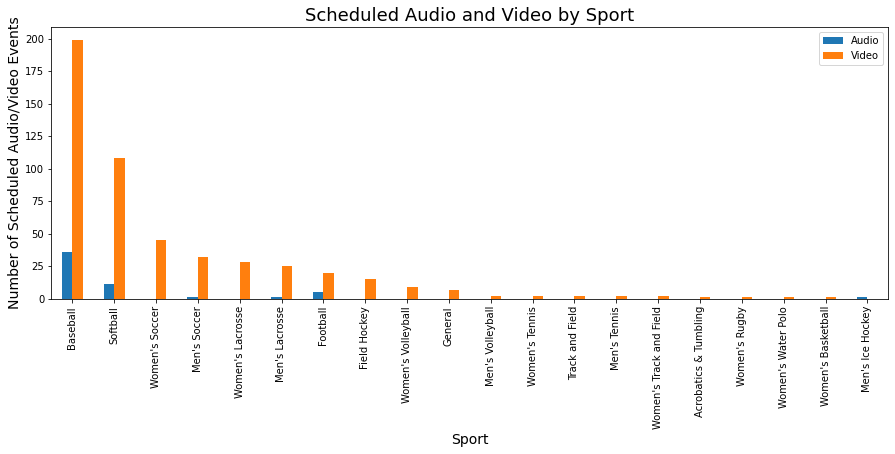

In [103]:
audio_video_per_sport.plot.bar(figsize = (15,5),rot = "vertical")
plt.title("Scheduled Audio and Video by Sport", fontsize = "18")
plt.xlabel("Sport", fontsize = "14")
plt.ylabel("Number of Scheduled Audio/Video Events", fontsize = "14")

In [16]:
#Step 1 - a copy of the dataframe is save to a file 
#output dataframe to CSV file - passthroughs accunted for - audio shown in pubPoint
#working_events.to_csv('NewPubPoints_in_events.csv')

### Final Data Frame 
* working_events is saved NewPubPoints_in_events.csv


### XXXXXX
* Export the city data into a .csv.
* Display the DataFrame